# STICS Applied on Simulation data

In this code the DataProcessing module was used by Jos de Wit.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import DataProcessingOCT
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import time
from scipy.optimize import curve_fit

In [3]:
# load the data
image_timeseries = np.load("timeseries512-512-10.npy")

In [4]:
image_timeseries.shape

(512, 512, 10)

In [5]:
# set some important parameters from the simulation
speed_of_flow = 2e-3 # meters per second
a_scan_rate = 5e3 # hertz
N_A_scans = 512   # number of A scans per B scan
N_B_scans = 50 # number of b scans
M = 1024

# from this calculate the b scan time:
b_scan_time = 1/a_scan_rate*N_A_scans

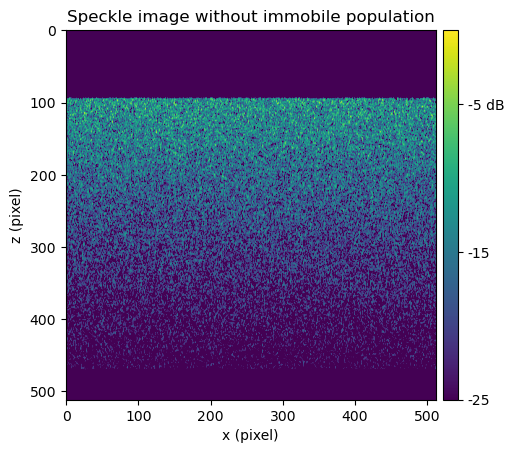

In [7]:
# create the average of the series and plot this
image_average = np.average(image_timeseries,2)

fig1,ax=DataProcessingOCT.plot_Bscan_image(image_timeseries[:,:,0],dBlevel=25,title='Speckle image without immobile population')
plt.show()

In [8]:
# plot the 3D data

# get the real part like data from measurements
real_intensity = np.abs(image_timeseries)

# creating the 3D plot
time_slice = 0
min_z = 0
max_z = 512

# set the to be plotted 3D array
plot_data = real_intensity[min_z:max_z,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = np.arange(x_axis_points)
y_axis = np.arange(y_axis_points)

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)


# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)

# Set ax labels
plt.xlabel("$x$ (pixel)")
plt.ylabel("$z$ (pixel)")
plt.title("Simulated OCT signal at $t={}$".format(time_slice))

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

Error in callback <function _draw_all_if_interactive at 0x7fe3a95c91b0> (for post_execute):


KeyboardInterrupt: 

## Immobile population removal

In [ ]:
# parameters for the heaviside function:
total_acquisition_time = b_scan_time*(N_B_scans-1)

# create the heaviside function:
H = np.zeros([int(M/2),N_A_scans,N_B_scans])

# check if frequency is higher than 1/T
for w in range(N_B_scans):
    if w>1/total_acquisition_time:
        H[:,:,w] = 1
    else:
        H[:,:,w] = 0.1e-19

# now implement the heaviside function on the image data in the fourier domain
intensity = np.fft.ifft(np.fft.fft(image_timeseries,axis=2)*H)

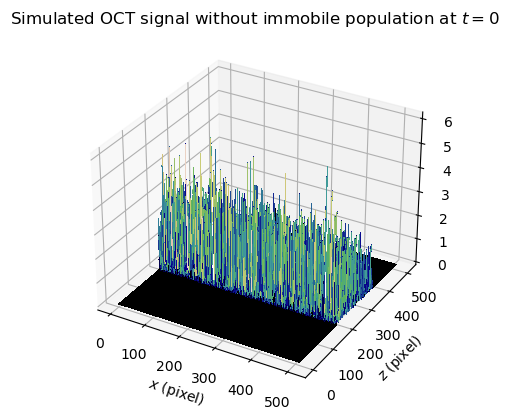

In [ ]:
# plot the data after removing immobile population:
# plot the 3D data

# get the real part like data from measurements
real_intensity = np.abs(image_timeseries)

# creating the 3D plot
time_slice = 0
min_z = 0
max_z = 512

# set the to be plotted 3D array
plot_data = np.abs(intensity)[min_z:max_z,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = np.arange(x_axis_points)
y_axis = np.arange(y_axis_points)

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Set ax labels
plt.xlabel("$x$ (pixel)")
plt.ylabel("$z$ (pixel)")
plt.title("Simulated OCT signal without immobile population at $t={}$".format(time_slice))

ls = LightSource(270, 45)

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

## Apply STICS autocorrelation function

Only correlates in positive time direction, correlates in  both negative and positive directions in spacial directions.
The correlation is only performed on spacial squares due to plotting limitations.

In [ ]:
# set correlation parameters
N_time_lags = 2
N_spacial_lags = 30 # should be an even number

# create real intensity similar to real OCT data
real_intensity = np.abs(intensity)

# retrieve maximum values
Z,X,T = real_intensity.shape

N = Z
M = Z

# create spacial lags array
spacial_lags = np.arange(-int(N_spacial_lags/2),int(N_spacial_lags/2))

# define correlation array 
correlation = np.zeros([N_spacial_lags,N_spacial_lags,N_time_lags])

# iterate over all lags
for m_index in range(N_spacial_lags):

    # set the m lag
    m = spacial_lags[m_index]

    for n_index in range(N_spacial_lags):

        # set the n lag
        n = spacial_lags[n_index]

        for delta_t in range(N_time_lags):

            # calculate the intensity fluctuations
            delta_i = (real_intensity - np.mean(real_intensity,axis=(0,1)))#/np.mean(real_intensity,axis=(0,1))
            delta_i_shifted = np.roll(delta_i,(-m,-n,delta_t),axis=(0,1,2))[:Z-abs(m),:X-abs(n),:T-delta_t]
            delta_i = delta_i[:Z-abs(m),:X-abs(n),:T-delta_t]

            # calculate the correlations
            correlation[m_index,n_index,delta_t] = np.correlate(delta_i.flatten(),delta_i_shifted.flatten())
            

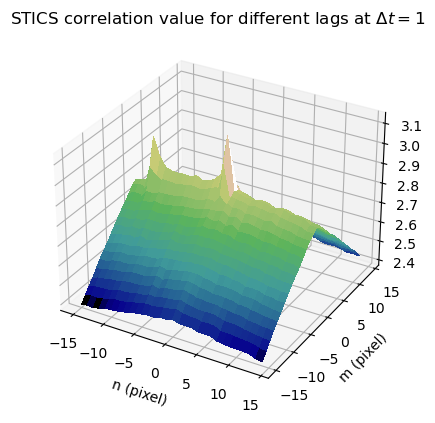

In [ ]:
# plot the correlation data in 3D

# get the real part like data from measurements
real_intensity = np.abs(image_timeseries)

# creating the 3D plot
time_slice = 1

# set the to be plotted 3D array
plot_data = correlation[:,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = spacial_lags
y_axis = spacial_lags

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)

#y_axis = np.linspace(min,max,points)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Set ax labels
plt.xlabel("n (pixel)")
plt.ylabel("m (pixel)")
plt.title("STICS correlation value for different lags at $\Delta t={}$".format(time_slice))

ls = LightSource(270, 45)

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

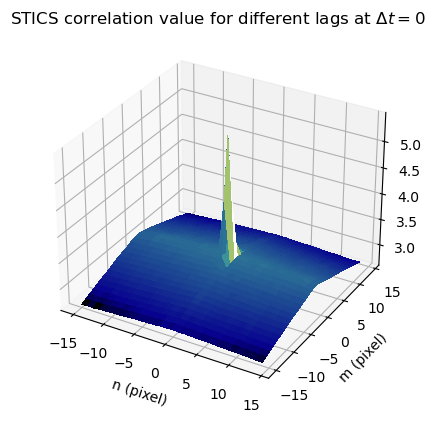

In [ ]:
# plot the correlation data in 3D

# set correlation parameters
N_time_lags = 2
N_spacial_lags = 30 # should be an even number

spacial_lags = np.arange(-int(N_spacial_lags/2),int(N_spacial_lags/2))

# get the real part like data from measurements
real_intensity = np.abs(image_timeseries)

# creating the 3D plot
time_slice = 0

# set the to be plotted 3D array
plot_data = correlation[:,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = spacial_lags
y_axis = spacial_lags

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)

#y_axis = np.linspace(min,max,points)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Set ax labels
plt.xlabel("n (pixel)")
plt.ylabel("m (pixel)")
plt.title("STICS correlation value for different lags at $\Delta t={}$".format(time_slice))

ls = LightSource(270, 45)

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

## STICS computational complexity calculation

In [ ]:
# create times
lags_array = [2,4,6,8,10,12,14,18,20,22]
#lags_array = [2,4,6,8]
times_data = np.zeros([len(lags_array)])

for iteration in range(len(lags_array)):

    # set correlation parameters
    N_spacial_lags = lags_array[iteration] # should be an even number
    N_time_lags = N_spacial_lags

    # start the timer
    t0 = time.time()


    # create real intensity similar to real OCT data
    real_intensity = np.abs(intensity)

    # retrieve maximum values
    Z,X,T = real_intensity.shape

    N = Z
    M = Z

    # create spacial lags array
    spacial_lags = np.arange(-int(N_spacial_lags/2),int(N_spacial_lags/2))

    # define correlation array 
    correlation = np.zeros([N_spacial_lags,N_spacial_lags,N_time_lags])

    # iterate over all lags
    for m_index in range(N_spacial_lags):

        # set the m lag
        m = spacial_lags[m_index]

        for n_index in range(N_spacial_lags):

            # set the n lag
            n = spacial_lags[n_index]

            for delta_t in range(N_time_lags):

                # calculate the intensity fluctuations
                delta_i = (real_intensity - np.mean(real_intensity,axis=(0,1)))#/np.mean(real_intensity,axis=(0,1))
                delta_i_shifted = np.roll(delta_i,(-m,-n,delta_t),axis=(0,1,2))[:Z-abs(m),:X-abs(n),:T-delta_t]
                delta_i = delta_i[:Z-abs(m),:X-abs(n),:T-delta_t]

                # calculate the correlations
                correlation[m_index,n_index,delta_t] = np.correlate(delta_i.flatten(),delta_i_shifted.flatten())

    t1 = time.time()
    times_data[iteration] = t1 - t0

In [ ]:
def cubed(x):
    return x**3

def squared(x):
    return x**2



/var/folders/pr/6q_l_1zj24jd7vbk3hccwh3h0000gn/T/ipykernel_54334/1834638766.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(lags_array,times_data,'--bo',color='red',label="Computation time")


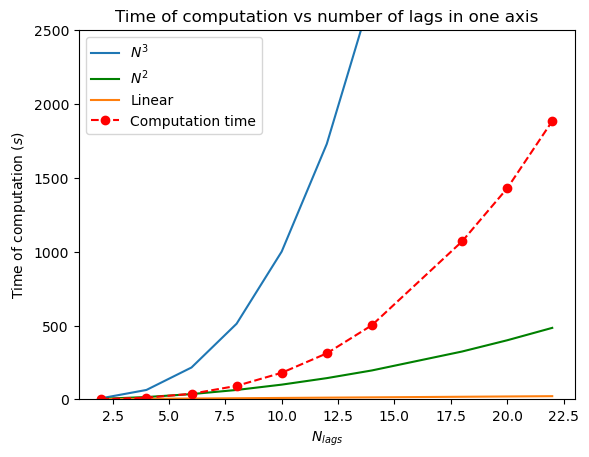

In [28]:
# plot the times data logarithmiclly
plt.plot(lags_array,cubed(np.array(lags_array)),label="$N^3$")
plt.plot(lags_array,squared(np.array(lags_array)),label="$N^2$",color='green')
plt.plot(lags_array,lags_array,label="Linear")
plt.plot(lags_array,times_data,'--bo',color='red',label="Computation time")
plt.ylim(bottom=0,top=2500)
plt.legend()
plt.xlabel("$N_{lags}$")
plt.ylabel("Time of computation ($s$)")
plt.title("Time of computation vs number of lags in one axis")
#plt.savefig("/Users/bramzijlstra/Desktop/!PDF_plots/Computation_time.pdf")
plt.show()

In [70]:
# hier de curvefit uitvoeren:
def power_law (x,a,k):
    return a*x**k

popt, pcov = curve_fit(power_law,lags_array[:],times_data[:])

perr = np.sqrt(np.diag(pcov))

a,k = popt
print("a=",a)
print("k=",k)
print(perr)

a= 0.22095810926304757
k= 2.9290024935215855
[0.01575611 0.02372765]


/var/folders/pr/6q_l_1zj24jd7vbk3hccwh3h0000gn/T/ipykernel_54334/724005226.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0,top=2500)


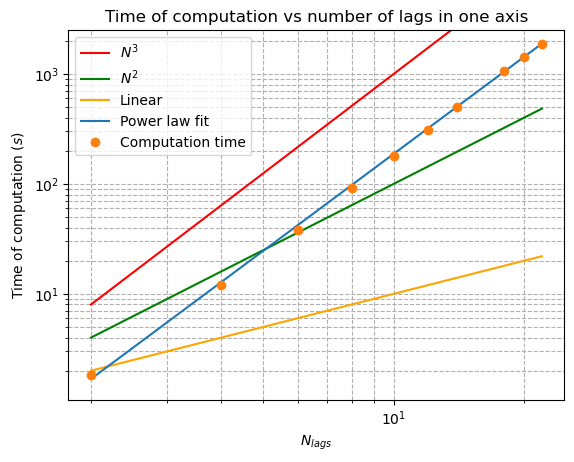

In [74]:
plt.loglog(lags_array,cubed(np.array(lags_array)),label="$N^3$",color='red')
plt.loglog(lags_array,squared(np.array(lags_array)),label="$N^2$",color='green')
plt.loglog(lags_array,lags_array,label="Linear",color='orange')
plt.loglog(lags_array,power_law(lags_array,a,k),label="Power law fit")
plt.loglog(lags_array,times_data,'o',label="Computation time")
plt.ylim(bottom=0,top=2500)
plt.legend()
plt.xlabel("$N_{lags}$")
plt.grid(True, which="both",ls='--')
plt.ylabel("Time of computation ($s$)")
plt.title("Time of computation vs number of lags in one axis")
#plt.savefig("/Users/bramzijlstra/Desktop/!PDF_plots/Computation_time_log.pdf")
plt.show()

In [32]:
#np.save("/Users/bramzijlstra/Desktop/Computation_times.npy",times_data)

## STICS without $z$ axis correlation:

In these correlation STICS the correlation is only applied on the $x$ and $t$ axis to be able to visualise the flow in the x direction at different depths in the sample.

In [29]:
# set correlation parameters
N_time_lags = 5

# set pixel range for correlation
min_z = int(512/2)-150
max_z = int(512/2)+150

N_x_lags = max_z-min_z

real_intensity = np.abs(intensity)
Z,X,T = real_intensity.shape

correlation_no_z = np.zeros([len(real_intensity[:,0,0]),N_x_lags,N_time_lags])

spacial_lags = np.arange(-int(N_x_lags/2),int(N_x_lags/2))
print(spacial_lags)

# iterate over all z values and different lags
for z_index in range(min_z,max_z):
    
    real_intensity_z = real_intensity[z_index,:,:]

    for n_index in range(N_x_lags):
        for delta_t in range(N_time_lags):


            # set the lag
            n = spacial_lags[n_index]

            # calculate the intensity fluctuations
            delta_i = (real_intensity_z-np.mean(real_intensity_z,axis=0))/np.mean(real_intensity_z,axis=0)
            delta_i_shifted = np.roll(delta_i,(-n,delta_t),axis=(0,1))[:X-abs(n),:T-delta_t]
            delta_i = delta_i[:X-abs(n),:T-delta_t]

            # set the correlation value
            correlation_no_z[z_index,n_index,delta_t] = np.correlate(delta_i.flatten(),delta_i_shifted.flatten())


[-150 -149 -148 -147 -146 -145 -144 -143 -142 -141 -140 -139 -138 -137
 -136 -135 -134 -133 -132 -131 -130 -129 -128 -127 -126 -125 -124 -123
 -122 -121 -120 -119 -118 -117 -116 -115 -114 -113 -112 -111 -110 -109
 -108 -107 -106 -105 -104 -103 -102 -101 -100  -99  -98  -97  -96  -95
  -94  -93  -92  -91  -90  -89  -88  -87  -86  -85  -84  -83  -82  -81
  -80  -79  -78  -77  -76  -75  -74  -73  -72  -71  -70  -69  -68  -67
  -66  -65  -64  -63  -62  -61  -60  -59  -58  -57  -56  -55  -54  -53
  -52  -51  -50  -49  -48  -47  -46  -45  -44  -43  -42  -41  -40  -39
  -38  -37  -36  -35  -34  -33  -32  -31  -30  -29  -28  -27  -26  -25
  -24  -23  -22  -21  -20  -19  -18  -17  -16  -15  -14  -13  -12  -11
  -10   -9   -8   -7   -6   -5   -4   -3   -2   -1    0    1    2    3
    4    5    6    7    8    9   10   11   12   13   14   15   16   17
   18   19   20   21   22   23   24   25   26   27   28   29   30   31
   32   33   34   35   36   37   38   39   40   41   42   43   44   45
   46 

In [1]:
# plot the correlation data in 3D

# creating the 3D plot
time_slice = 0

# set the to be plotted 3D array
plot_data = correlation_no_z[min_z:max_z,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = spacial_lags
y_axis = np.arange(min_z,max_z)

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)

#y_axis = np.linspace(min,max,points)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Set ax labels
plt.xlabel("n (pixel)")
plt.ylabel("$z$ (pixel)")
plt.title("STICS correlation value without $z$ correlation for different lags at $\Delta t={}$".format(time_slice))

ls = LightSource(270, 45)

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

NameError: name 'correlation_no_z' is not defined

In [51]:
# quickly retrieve position of highest value of 
print(np.argmax(correlation_no_z[256,:,0]),"Is the highest value at t=0")
print(np.argmax(correlation_no_z[256,:,4]),"Is the highest value at t=1")

150 Is the highest value at t=0
216 Is the highest value at t=1


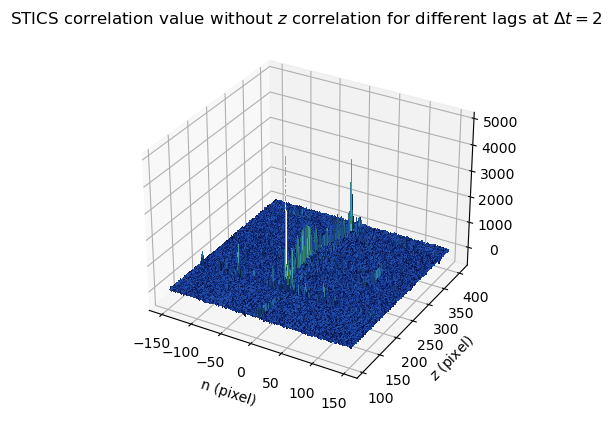

In [54]:
# plot the correlation data in 3D

# creating the 3D plot
time_slice = 2

# set the to be plotted 3D array
plot_data = correlation_no_z[min_z:max_z,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = spacial_lags
y_axis = np.arange(min_z,max_z)

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)

#y_axis = np.linspace(min,max,points)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Set ax labels
plt.xlabel("n (pixel)")
plt.ylabel("$z$ (pixel)")
plt.title("STICS correlation value without $z$ correlation for different lags at $\Delta t={}$".format(time_slice))

ls = LightSource(270, 45)

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)